# Kinoshita-type River Transect Example

This notebook showcases an example of the _WigglyRivers_ tool by creating, extracting, and interpreting the meandering features of Kinoshita-type river transects. The Kinoshita curve can be estimated using the the function `RiverFunctions.kinoshita_curve_zolezzi(...)`. This equation uses the equations of the Kinoshita curve provided by Zolezzi and Güneralp (2016). The Kinoshita curve uses the following equations to calculate the direction angle ($\theta$) and the curvature ($C$).

$$\theta = \theta_0 \cos(\kappa s) + \theta_{s} \sin(3\kappa s) + \theta_f \cos(3\kappa s)$$

$$C=\kappa[\theta_0 \sin(\kappa s) - 3\theta_s\cos(3\kappa s) + 3\theta_f\sin(3\kappa s)]$$

where $\kappa=2\pi/\lambda$, $\lambda$ is the wavelength of the meander, $\theta_0$ is the amplitude of the direction angle oscillation, and $\theta_s$ and $\theta_f$ are the skewness and fatness coefficients, respectivelly.

## Import Packages

To start with this workflow we first import the packages necessary to run the code.

In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib ipympl

In [2]:
# Importing Packages
import os
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from IPython.display import Image, display, HTML
from IPython.display import display
from scipy.signal import find_peaks


# Importing WigglyRivers Packages
from WigglyRivers import RiverDatasets
from WigglyRivers import RiverFunctions as RF
from WigglyRivers.utilities import utilities as utl
from WigglyRivers.utilities import filesManagement as FM
from WigglyRivers import Logger
from WigglyRivers import graphs

# Set seed for numpy
np.random.seed(0)

Wiggly Rivers can work with a logger that prints the process of the methods. You can call the `Logger` class to create a logger object and pass it as an argument to the methods that you want to log. If you don't want to log the process, you can pass `None` as an argument.

In [3]:
# Start Logger to keep track of the code, not needed to run the codes
logger = Logger(console=True)

2024-05-18 09:30:40,610[INFO] set_logger: Starting log


## Kinoshita-type River Transect Examples

### River Transect Multiscale Characterization

In the following code blocks, we will be using the spectral tools within _WigglyRivers_ to explore the multiscale nature of ideal river transects created with the Kinoshita curves. We approach this characterization in two parts. First, we explored three Kinoshita-type river transects with 40 meander bends that have the same wavelength ($\lambda=100$ m), skewness ($\theta_s=0.344$), and fatness ($\theta_f=0.031$) but vary in the amplitude of the direction angle oscillation as $\theta_0=[37.24, 60, 120]$. 


In [4]:
# -----------------------------------------------
# Functions for Kinoshita Curve exploration
# -----------------------------------------------
def explore_kinoshita_values(theta_0, lambda_value, theta_s, theta_f, n,
                             plot_flag=False):
    x_k, y_k, data = RF.kinoshita_curve_zolezzi(
        theta_0=theta_0, lambda_value=lambda_value, theta_s=theta_s,
        theta_f=theta_f, n=n)
    w_m = np.ones_like(x_k)
    # Create River Object
    rivers_k = RiverDatasets(logger=logger)
    rivers_k.add_river('0', x_k, y_k, w_m=w_m, resample_flag=True,
                       kwargs_resample={}, scale_by_width=False)
    # Calculate curvature
    rivers_k['0'].calculate_curvature()
    # Calculate CWT
    rivers_k['0'].get_cwt_curvature(mother='MORLET')
    rivers_k['0'].get_cwt_angle(mother='MORLET')
    results = {
        'rivers': rivers_k,
    }
    return results


2024-05-18 09:30:45,028[INFO] info: Start Logger in RiverDatasets
2024-05-18 09:30:45,161[INFO] info: Start Logger in RiverDatasets
2024-05-18 09:30:45,291[INFO] info: Start Logger in RiverDatasets


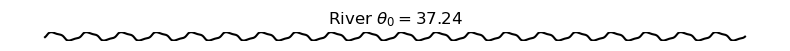

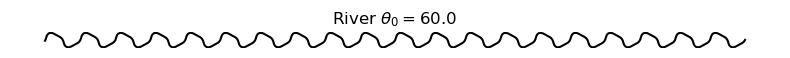

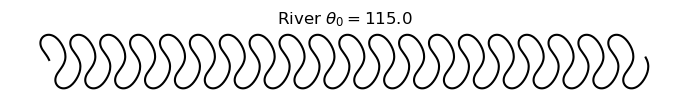

In [5]:
# -----------------------------------------------
# Creation of the Kinoshita-type River transects
# -----------------------------------------------
theta_0 = np.array([37.24, 60, 115])  # Degrees
theta_s = np.array([0.344, 0.344, 0.344])
theta_f = 0.031
lambda_value = 100
n = 20
variables = ['rivers']
results_theta = {i: [] for i in variables}
# Explore values
for i in range(len(theta_0)):
    result = explore_kinoshita_values(
        theta_0[i]*np.pi/180, lambda_value, theta_s[i], theta_f, n)
    for var in variables:
        results_theta[var].append(result[var])

# --------------
# Plot Rivers
# --------------
utl.cr_folder('kinoshita_results/')
river_ids = np.arange(len(theta_0))
for river_id in river_ids:
    x_ch = results_theta['rivers'][river_id]['0'].x
    y_ch = results_theta['rivers'][river_id]['0'].y
    plt.figure(figsize=(8, 1))
    plt.plot(x_ch, y_ch, '-k')
    # plt.plot(x_ch, y_ch, 'ob')
    plt.title(f'River $\\theta_0={theta_0[river_id]}$')
    plt.gca().set_aspect('equal', adjustable='box')
    # Remove ticks
    plt.xticks([])
    plt.yticks([])
    # Remove axis lines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.tight_layout()
    plt.savefig(f'kinoshita_results/river_{river_id}.png', dpi=300)


#### Spectral Analysis

Within the function `explore_kinoshita_values()` we calculate the curvature ($C$) and the direction angle ($\theta$) and apply a Continous Wavelet Transform (CWT) to these variables to gain insight into the spectral properties of these river transects. Finally, we calculate the global wavelet spectrum (GWS) and the scale-averaged wavelet power (SAWP) over the significant scales of the CWT. On this first analysis we are interested in looking into the periodicity of the meander bends, thus we decided to use the Morlet mother wavelet, similarly to what was done by Zolezzi and Güneralp (2016).

The following code blocks below will create the compiled figures of all the river transects with 95% significance.

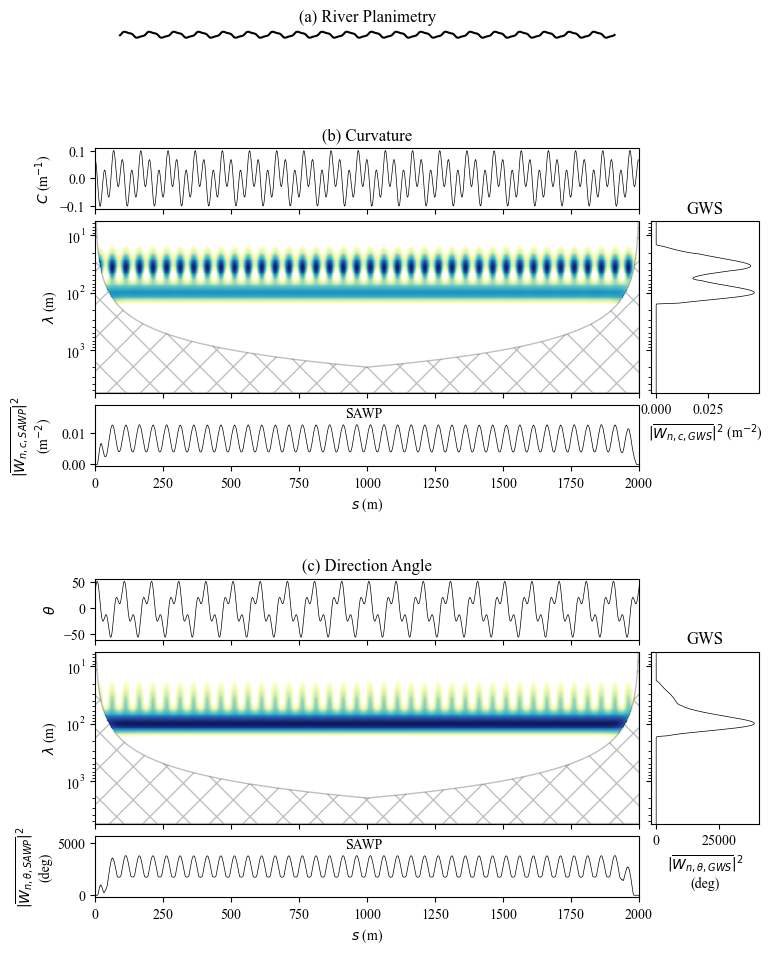

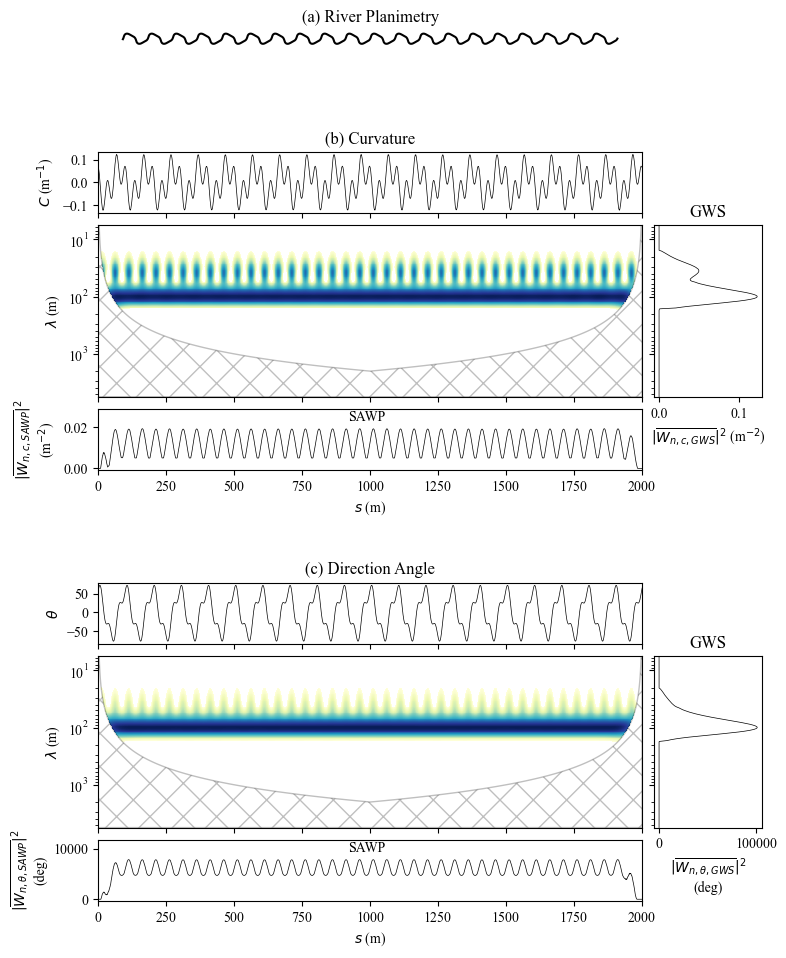

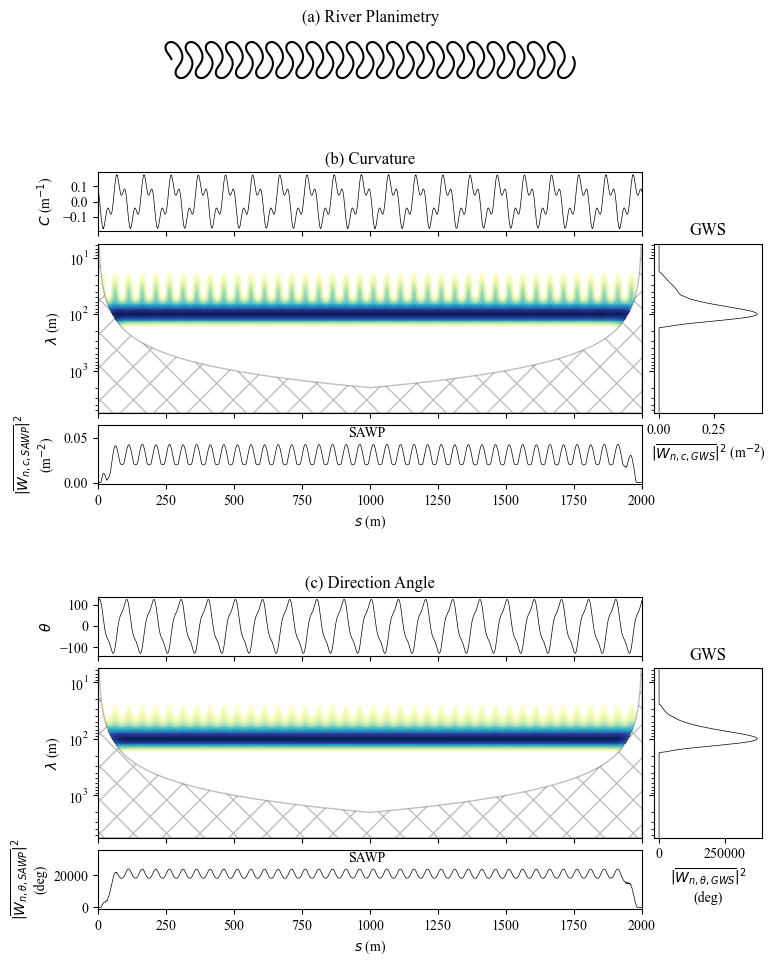

In [6]:
# Plot Condense analysis only presenting values for the 95% significance 
fs = 11
mpl.rcParams['font.size'] = fs
mpl.rcParams['font.family'] = 'Times New Roman'
plt.close('all')
for i in range(len(theta_0)):
    river = results_theta['rivers'][i]['0']
    graphs.plot_river_spectrum_compiled(river, only_significant=True)
    utl.cr_folder('../manuscript_figures/')
    if i == 0:
        plt.savefig(f'../manuscript_figures/Figure_04_kinoshita_river_{i}_sig95.png', dpi=500)
    elif i == 2:
        plt.savefig(f'../manuscript_figures/Figure_05_kinoshita_river_{i}_sig95.png', dpi=500)
    else:
        plt.savefig(f'../manuscript_figures/Figure_S2_kinoshita_river_{i}_sig95.png', dpi=500)



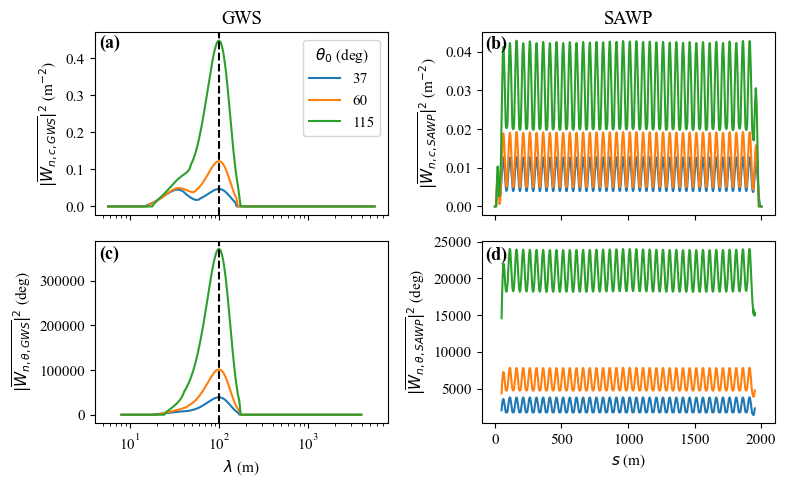

In [7]:
# --------------------
# Plot GWS information
# --------------------
fs = 11
mpl.rcParams['font.size'] = fs
plt.close('all')
f, ax = plt.subplots(2, 2, figsize=(8, 5), sharex='col')
ax = ax.ravel()
i_dat = 0
ax[i_dat].set_title('GWS')
for i in range(len(theta_0)):
    ax[i_dat].plot(results_theta['rivers'][i]['0'].cwt_wavelength_c,
                   results_theta['rivers'][i]['0'].cwt_gws_c_sig,
                   label=f'{theta_0[i]:.0f}')
# ax[i_dat].set_xlabel(f'$\lambda$ (m)')
ax[i_dat].axvline(lambda_value, color='k', linestyle='--')
ax[i_dat].set_ylabel(r"$|\overline{W_{n,c,GWS}}|^2$ (m$^{-2}$)")
ax[i_dat].set_xscale('log')
ax[i_dat].legend(title='$\\theta_0$ (deg)')

i_dat = 2
# ax[i_dat].set_title('Angle')
for i in range(len(theta_0)):
    ax[i_dat].plot(results_theta['rivers'][i]['0'].cwt_wavelength_angle[10:-10],
             results_theta['rivers'][i]['0'].cwt_gws_angle_sig[10:-10],
             label=f'{theta_0[i]:.0f}')
ax[i_dat].set_xlabel(r'$\lambda$ (m)')
ax[i_dat].set_ylabel(r"$|\overline{W_{n,\theta,GWS}}|^2$ (deg)")
ax[i_dat].axvline(lambda_value, color='k', linestyle='--')
ax[i_dat].set_xscale('log')

i_dat = 1
ax[i_dat].set_title('SAWP')
for i in range(len(theta_0)):
    ax[i_dat].plot(results_theta['rivers'][i]['0'].s,
                   results_theta['rivers'][i]['0'].cwt_sawp_c_sig,
                   label=f'{theta_0[i]:.0f}')
# ax[i_dat].set_xlabel('Wavelength (m)')
ax[i_dat].set_ylabel(r"$|\overline{W_{n,c,SAWP}}|^2$ (m$^{-2}$)")
# ax[i_dat].axvline(lambda_value, color='k', linestyle='--')
# ax[i_dat].set_ylabel('Power$^2$')
# ax[i_dat].set_xscale('log')
# ax[i_dat].legend(title='$\\theta_0$ (deg)')

i_dat = 3
# ax[i_dat].set_title('Angle')
for i in range(len(theta_0)):
    ax[i_dat].plot(results_theta['rivers'][i]['0'].s[50:-50],
             results_theta['rivers'][i]['0'].cwt_sawp_angle_sig[50:-50],
             label=f'{theta_0[i]:.0f}')
ax[i_dat].set_ylabel(r"$|\overline{W_{n,\theta,SAWP}}|^2$ (deg)")
ax[i_dat].set_xlabel('$s$ (m)')
# ax[i_dat].set_xlim([160, 160+50])

# Literals
f.text(0.145, 0.89, '(a)', ha='center', fontsize=fs + 2, weight='bold')
f.text(0.629, 0.89, '(b)', ha='center', fontsize=fs + 2, weight='bold')
f.text(0.145, 0.469, '(c)', ha='center', fontsize=fs + 2, weight='bold')
f.text(0.629, 0.469, '(d)', ha='center', fontsize=fs + 2, weight='bold')


plt.tight_layout()
utl.cr_folder('../manuscript_figures/')
plt.savefig(f'../manuscript_figures/Figure_06_compare_GWS_theta_angle.png', dpi=500)
plt.show()

For the following example, we explore the effects of variations in the wavelength ($\lambda$) of the Kinoshita curve. We create a single meander reach where the wavelength is varying every 5 meander beds as follows $\lambda=[50, 100, 200, 500, 1000]$. The other parameters are kept constant as $\theta_0=110$, $\theta_s=0.344$, and $\theta_f=0.031$. The following code blocks below will create the compiled figures of all the river transects with and without 95% significance.

In [8]:
# Vary lambda
theta_0 = 110
theta_s = 0.344
theta_f = 0.031
# theta_s = 0
# theta_f = 0
lambda_value = [50, 100, 200, 500]
n = 5
# variables = ['rivers', 's', 'c', 'theta', 'cwt_morlet_angle',
#              'power_morlet_angle', 'wavelen_morlet_angle', 'gws_angle',
#              'sum_wave_angle', 'cwt_morlet_c', 'power_morlet_c',
#              'wavelen_morlet_c', 'gws_c', 'sum_wave_c']
variables = ['rivers']

results_lambda = {i: [] for i in variables}

for i in range(len(lambda_value)):
    result = explore_kinoshita_values(
        theta_0*np.pi/180, lambda_value[i], theta_s, theta_f, n)

    if i == 0:
        results_lambda['rivers'] = result['rivers']
    else:
        results_lambda['rivers']['0'].x = np.concatenate(
            (results_lambda['rivers']['0'].x[:-2], result['rivers']['0'].x + results_lambda['rivers']['0'].x[-1]))
        results_lambda['rivers']['0'].y = np.concatenate(
            (results_lambda['rivers']['0'].y[:-2], result['rivers']['0'].y))
        results_lambda['rivers']['0'].w_m = np.concatenate(
            (results_lambda['rivers']['0'].w_m, result['rivers']['0'].w_m))
        results_lambda['rivers']['0'].s = np.concatenate(
            (results_lambda['rivers']['0'].s, result['rivers']['0'].s + np.max(results_lambda['rivers']['0'].s)))

x = results_lambda['rivers']['0'].x
y = results_lambda['rivers']['0'].y
w_m = np.ones_like(x)

rivers_lambda = RiverDatasets(logger=logger)
rivers_lambda.add_river('0', x, y, w_m=w_m, resample_flag=True,
                        kwargs_resample={}, scale_by_width=False)

# Calculate curvature and angle
rivers_lambda['0'].calculate_curvature()
rivers_lambda['0'].get_cwt_curvature(mother='MORLET')
rivers_lambda['0'].get_cwt_angle(mother='MORLET')

2024-05-18 09:31:33,681[INFO] info: Start Logger in RiverDatasets
2024-05-18 09:31:33,711[INFO] info: Start Logger in RiverDatasets
2024-05-18 09:31:33,745[INFO] info: Start Logger in RiverDatasets
2024-05-18 09:31:33,809[INFO] info: Start Logger in RiverDatasets
2024-05-18 09:31:33,959[INFO] info: Start Logger in RiverDatasets


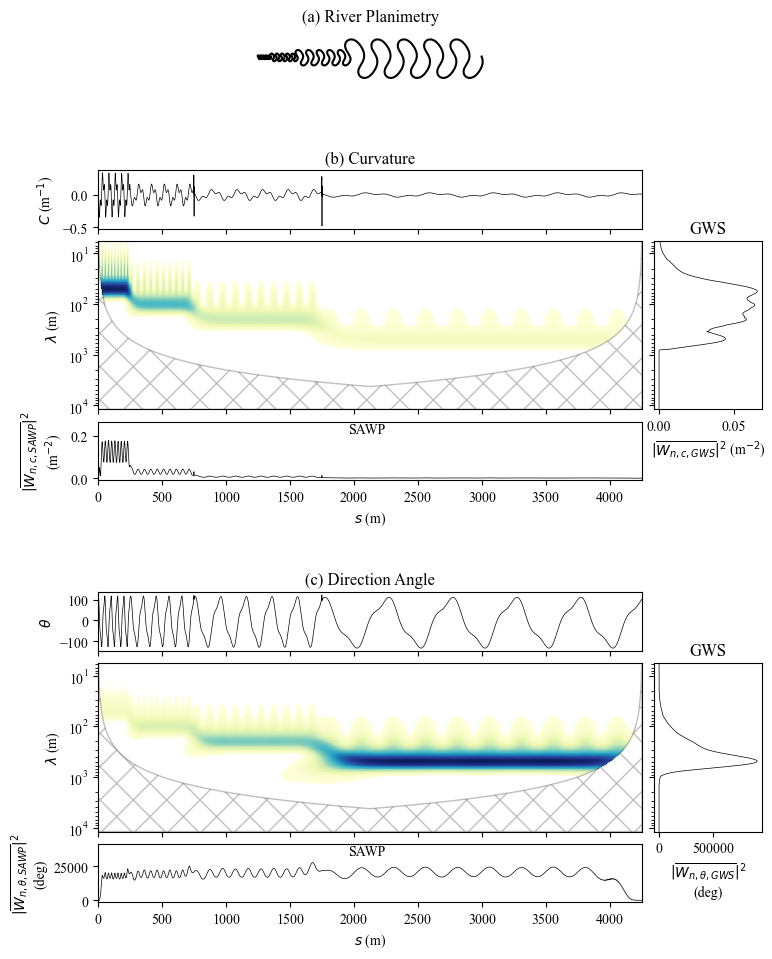

In [9]:
# Plot metrics with only significant values
river = rivers_lambda['0']
graphs.plot_river_spectrum_compiled(river, only_significant=True)
utl.cr_folder('../manuscript_figures/')
plt.savefig('../manuscript_figures/Figure_07_kinoshita_lambda_sig.png', dpi=500)
# plt.savefig('../manuscript_figures/Figure_07_kinoshita_lambda_sig.pdf', dpi=500)


We aslo expore a system with no skewness and fatness, $\theta_s=0$, $\theta_f=0$, and $\theta_0=110$. The following code blocks below will create the compiled figures of all the river transects with and without 95% significance.

In [10]:
# Vary lambda
theta_0 = 110
# theta_s = 0.344
# theta_f = 0.031
theta_s = 0
theta_f = 0
lambda_value = [50, 100, 200, 500]
n = 5
# variables = ['rivers', 's', 'c', 'theta', 'cwt_morlet_angle',
#              'power_morlet_angle', 'wavelen_morlet_angle', 'gws_angle',
#              'sum_wave_angle', 'cwt_morlet_c', 'power_morlet_c',
#              'wavelen_morlet_c', 'gws_c', 'sum_wave_c']
variables = ['rivers']

results_lambda = {i: [] for i in variables}

for i in range(len(lambda_value)):
    result = explore_kinoshita_values(
        theta_0*np.pi/180, lambda_value[i], theta_s, theta_f, n)

    if i == 0:
        results_lambda['rivers'] = result['rivers']
    else:
        results_lambda['rivers']['0'].x = np.concatenate(
            (results_lambda['rivers']['0'].x[:-2], result['rivers']['0'].x + results_lambda['rivers']['0'].x[-1]))
        results_lambda['rivers']['0'].y = np.concatenate(
            (results_lambda['rivers']['0'].y[:-2], result['rivers']['0'].y))
        results_lambda['rivers']['0'].w_m = np.concatenate(
            (results_lambda['rivers']['0'].w_m, result['rivers']['0'].w_m))
        results_lambda['rivers']['0'].s = np.concatenate(
            (results_lambda['rivers']['0'].s, result['rivers']['0'].s + np.max(results_lambda['rivers']['0'].s)))

x = results_lambda['rivers']['0'].x
y = results_lambda['rivers']['0'].y
w_m = np.ones_like(x)

rivers_lambda = RiverDatasets(logger=logger)
rivers_lambda.add_river('0', x, y, w_m=w_m, resample_flag=True,
                        kwargs_resample={}, scale_by_width=False)

# Calculate curvature and angle
rivers_lambda['0'].calculate_curvature()
rivers_lambda['0'].get_cwt_curvature(mother='MORLET')
rivers_lambda['0'].get_cwt_angle(mother='MORLET')

2024-05-18 09:31:45,436[INFO] info: Start Logger in RiverDatasets
2024-05-18 09:31:45,457[INFO] info: Start Logger in RiverDatasets
2024-05-18 09:31:45,494[INFO] info: Start Logger in RiverDatasets
2024-05-18 09:31:45,559[INFO] info: Start Logger in RiverDatasets
2024-05-18 09:31:45,706[INFO] info: Start Logger in RiverDatasets


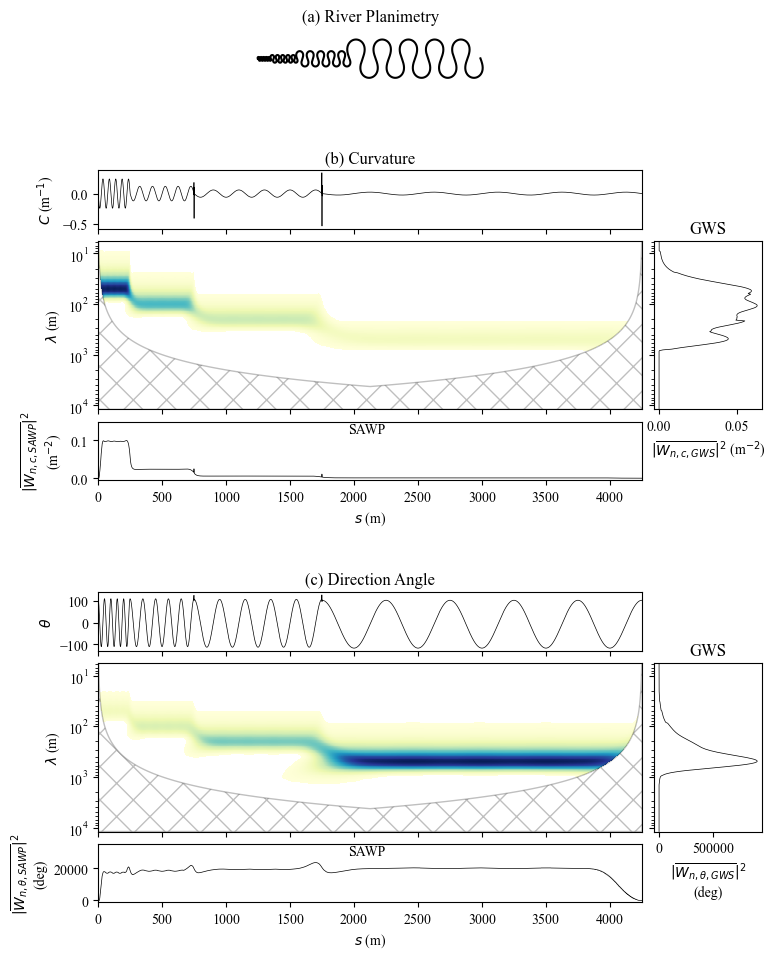

In [11]:
# Plot metrics with only significant values
river = rivers_lambda['0']
graphs.plot_river_spectrum_compiled(river, only_significant=True)
utl.cr_folder('../manuscript_figures/')
plt.savefig('../manuscript_figures/Figure_S3_kinoshita_lambda_sig.png', dpi=500)
# plt.savefig('../manuscript_figures/Figure_S3_kinoshita_lambda_sig.pdf', dpi=500)


### Unsupervised Identification Tool

In the following code blocks we will use the last generated river transect to showcase the unsupervised meander identification tool.

#### Process to perform unsupervised Identification

The process to perform the automatic detection from a created rivers object involves the following steps:

1. **Calculate curvature**: Use the function `rivers[id_river].calculate_curvature()` to estimate the curvature of the river transect.

2. **Calculate Continous Wavelet Transform (CWT) of the curvature and extract tree**: Use the function `rivers[id_river].extract_cwt_tree()` to estimate the CWT of the curvature and extract the CWT tree where the important wavelengths are mapped throughout the network.

3. **Prune Peak Power**: Use the function `rivers[id_river].prune_tree_by_peak_power()` to prune the tree by the peak power of the CWT.

4. **Prune by sinuosity**: Use the function `rivers[id_river].prune_tree_by_sinuosity(1.01)` to prune the tree by the sinuosity of the river.

5. **Add meanders to database**: Use the function `rivers[id_river].add_meanders_from_tree_scales(bounds_array_str='extended')` to add the meanders to the database.

In [12]:
# ------------------------------
# Generate River Network
# ------------------------------
# Vary lambda
theta_0 = 110
theta_s = 0.344
theta_f = 0.031
# theta_s = 0
# theta_f = 0
lambda_value = [50, 100, 200, 500]
n = 5
# variables = ['rivers', 's', 'c', 'theta', 'cwt_morlet_angle',
#              'power_morlet_angle', 'wavelen_morlet_angle', 'gws_angle',
#              'sum_wave_angle', 'cwt_morlet_c', 'power_morlet_c',
#              'wavelen_morlet_c', 'gws_c', 'sum_wave_c']
variables = ['rivers']

results_lambda = {i: [] for i in variables}

for i in range(len(lambda_value)):
    result = explore_kinoshita_values(
        theta_0*np.pi/180, lambda_value[i], theta_s, theta_f, n)

    if i == 0:
        results_lambda['rivers'] = result['rivers']
    else:
        results_lambda['rivers']['0'].x = np.concatenate(
            (results_lambda['rivers']['0'].x[:-2], result['rivers']['0'].x + results_lambda['rivers']['0'].x[-1]))
        results_lambda['rivers']['0'].y = np.concatenate(
            (results_lambda['rivers']['0'].y[:-2], result['rivers']['0'].y))
        results_lambda['rivers']['0'].w_m = np.concatenate(
            (results_lambda['rivers']['0'].w_m, result['rivers']['0'].w_m))
        results_lambda['rivers']['0'].s = np.concatenate(
            (results_lambda['rivers']['0'].s, result['rivers']['0'].s + np.max(results_lambda['rivers']['0'].s)))

x = results_lambda['rivers']['0'].x
y = results_lambda['rivers']['0'].y
w_m = np.ones_like(x)

rivers_lambda = RiverDatasets(logger=logger)
river_id = r'Idealized River Transect ($\lambda=[50,100,200,500]$)'
rivers_lambda.add_river(river_id, x, y, w_m=w_m, resample_flag=True,
                        kwargs_resample={}, scale_by_width=False)

2024-05-18 09:31:57,718[INFO] info: Start Logger in RiverDatasets
2024-05-18 09:31:57,740[INFO] info: Start Logger in RiverDatasets
2024-05-18 09:31:57,771[INFO] info: Start Logger in RiverDatasets
2024-05-18 09:31:57,846[INFO] info: Start Logger in RiverDatasets
2024-05-18 09:31:57,997[INFO] info: Start Logger in RiverDatasets


In [13]:
# Calculate curvature
rivers_lambda[river_id].calculate_curvature()
# =================================
# Extract Meanders
# =================================
# --------------------
# Calculate CWT
# --------------------
rivers_lambda[river_id].extract_cwt_tree()
# -----------------------------
# Prune by peak power
# -----------------------------
rivers_lambda[river_id].prune_tree_by_peak_power()
# -----------------------------
# Prune by sinuosity
# -----------------------------
rivers_lambda[river_id].prune_tree_by_sinuosity(1.01)
# -----------------------------
# Add meander to database
# -----------------------------
rivers_lambda[river_id].add_meanders_from_tree_scales(
    overwrite=True, clip='downstream', bounds_array_str='extended')
# ---------------------------
# Calculate reach sinuosity
# ---------------------------
rivers_lambda[river_id].calculate_reach_metrics()


2024-05-18 09:31:59,971[INFO] info:   Running CWT...
2024-05-18 09:32:00,139[INFO] info:   Getting the scale tree...
2024-05-18 09:32:02,104[INFO] info:   Finding peaks in CWT...
2024-05-18 09:32:02,288[INFO] info:   Detecting meanders...
2024-05-18 09:32:02,309[INFO] info:   Projecting tree in planimetry...


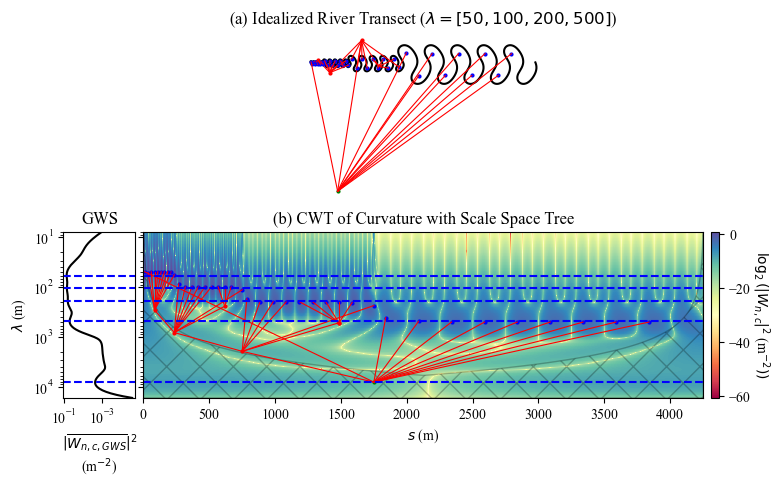

In [14]:
# Look at the meanders
plt.close('all')
fs = 10
mpl.rcParams['font.size'] = fs
rivers_lambda[river_id].plot_tree_nodes(markersize=2, linewidth=0.8)
plt.savefig('../manuscript_figures/Figure_08_kinoshita_automated_detection.png', dpi=500)

# References

Zolezzi, G., & Güneralp, I. (2016). Continuous wavelet characterization of the wavelengths and regularity of meandering rivers. Geomorphology, 252, 98–111. https://doi.org/10.1016/j.geomorph.2015.07.029
